# Asexual models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.5 MB/s eta 0:00:00

real	0m17.484s
user	0m8.342s
sys	0m1.416s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
# import scipy as sp
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

import random
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


In [ ]:
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit'])
axl=dff
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

,mol,Hit
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No


# Molecular Morgan Fingerprint (MFP)

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit


def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Target,Input
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)

## Hyperparameter tuning


---



---



In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto",class_weight='balanced', probability=True)
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto", class_weight='balanced', probability=True)

In [ ]:
## https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)# Train a SVC model using different kernal
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      5870
           1       0.00      0.00      0.00      6036

    accuracy                           0.49     11906
   macro avg       0.25      0.50      0.33     11906
weighted avg       0.24      0.49      0.33     11906



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5870
           1       0.92      0.88      0.90      6036

    accuracy                           0.90     11906
   macro avg       0.91      0.91      0.90     11906
weighted avg       0.91      0.90      0.90     11906

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5870
           1       0.91      0.88      0.89      6036

    accuracy                           0.89     11906
   macro avg       0.89      0.89      0.89     11906
weighted avg       0.89      0.89      0.89     11906



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid,cv=KFold(n_splits=3), refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(Xt_train, Yt_train)

In [ ]:
print(grid.best_params_) # Note these parameters (C and gamma) gave the same performance as default parameters but took very long in model building (5+ hours), hence default parameters were chosen

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


## Training

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(Xt_train, Yt_train)

In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'asexualsSVCFinalHPT_UMFP_model5005.pkl'
joblib.dump(svc_model, filename)

#Load Asexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("asexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,Hit,Smiles
0,51742,<rdkit.Chem.rdchem.Mol object at 0x7f71149bf680>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,20279,<rdkit.Chem.rdchem.Mol object at 0x7f7114ed6180>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,17729,<rdkit.Chem.rdchem.Mol object at 0x7f71219e38b0>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,28545,<rdkit.Chem.rdchem.Mol object at 0x7f7114dc26c0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,24371,<rdkit.Chem.rdchem.Mol object at 0x7f7114f4b140>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...,...
61024,72080,<rdkit.Chem.rdchem.Mol object at 0x7f7114740cf0>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,49244,<rdkit.Chem.rdchem.Mol object at 0x7f7114b4a340>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,47413,<rdkit.Chem.rdchem.Mol object at 0x7f7114afbae0>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,73164,<rdkit.Chem.rdchem.Mol object at 0x7f711476eb20>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl=dff
axl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f7113906500>,No,O=C(NCCCN1CCOCC1)C1CCCN(Cc2ccco2)C1
1,<rdkit.Chem.rdchem.Mol object at 0x7f7113906960>,No,Cc1nocc1C(=O)N1CCCC2(CCN(c3cnn(C)c3)C2=O)C1
2,<rdkit.Chem.rdchem.Mol object at 0x7f7113907680>,No,Cn1cncc1-c1nnc([C@H]2CCN(Cc3cccnc3)C2)o1
3,<rdkit.Chem.rdchem.Mol object at 0x7f71139061f0>,No,CCn1nc(C)c2nc(C(C)C)nc(NCC(C)C)c21
4,<rdkit.Chem.rdchem.Mol object at 0x7f7113906c00>,No,CN(C)CC1(O)CCCN(Cc2ccccc2OCC(=O)N(C)C)C1
...,...,...,...
61024,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2ef80>,No,N#Cc1cccc(NC(=O)NC2CCN(CCCCCNC(=O)/C=C/c3ccc(C...
61025,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2eff0>,No,NC1(C(=O)NCC2CCCN(Cc3cccc4nonc34)C2)CCC1
61026,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f060>,No,CNC(=O)C1CCCN(c2nc(-c3ccco3)nc3c2CCNCC3)C1
61027,<rdkit.Chem.rdchem.Mol object at 0x7f7112d2f0d0>,No,CC(Cc1ccc(OC2CCCCC2)cc1)NCC(O)c1cccc(Cl)c1.Cl


In [ ]:
## Convert test set mols into Mfp
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
axl["Hit"].value_counts()
def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

#axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Smiles,Target
32262,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ddcba0>,No,CCS(=O)(=O)N1CCC2(CC(=O)N(c3cccc(C)c3)C2)C1,0
22661,<rdkit.Chem.rdchem.Mol object at 0x7f1c23a3f610>,No,Cc1cc(C(=O)CN2C(=O)c3ccccc3CS2(=O)=O)c(C)[nH]1,0
28881,<rdkit.Chem.rdchem.Mol object at 0x7f1c21f3b300>,No,CCn1cc(CNC2CCN(c3cccc(Cl)c3)C2)cn1,0
26053,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ec1310>,No,COc1cc(N2C[C@@H]3COC[C@]3(COCc3ccccn3)C2)ncn1,0
24909,<rdkit.Chem.rdchem.Mol object at 0x7f1c21e957e0>,No,COCc1nc(C(=O)N2CCN(c3nccc(OC)n3)CC2)cs1,0
...,...,...,...,...
82363,<rdkit.Chem.rdchem.Mol object at 0x7f1c21683df0>,No,CCCCNc1c(C(=O)OCC)c(C)nc2c1[nH]c1ccccc12,0
59195,<rdkit.Chem.rdchem.Mol object at 0x7f1c21a80b30>,No,COc1ccc(-c2c[nH]c(C3CC(=O)N(CC(C)C)C3)n2)cc1,0
62561,<rdkit.Chem.rdchem.Mol object at 0x7f1c218a9af0>,No,CN1CCN(C2CCN(CCOc3cccc(Cl)c3)CC2)C1=O,0
18045,<rdkit.Chem.rdchem.Mol object at 0x7f1c23bf86d0>,No,Cc1nc(CCNC(=O)NCC(c2ccco2)N(C)C)cs1,0


In [ ]:
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
Xt_test = df
Yt_test= axl["Target"]

0    58241
1     2788
Name: Target, dtype: int64


# SVC

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

In [ ]:

svc_model = joblib.load('asexualsSVCFinalHPT_UMFP_model5005.pkl')

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

svc_predict = svc_model.predict(Xt_test)# check performance


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,svc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,svc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,svc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,svc_predict)
print('F1 score: %f' % f1)
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, svc_predict))
print('Accuracy score:',accuracy_score(Yt_test, svc_predict))
print('F1 score:',f1_score(Yt_test, svc_predict))
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, svc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, svc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, svc_predict)
print(matrix)
cm= confusion_matrix(Yt_test,svc_predict)
cm

Accuracy: 0.853234
Recall 0.898852
precision 0.224130
F1 score: 0.358794
ROCAUC score: 0.8749510857238748
Accuracy score: 0.8532337085647806
F1 score: 0.35879447347698473
Cohens kappa: 0.308203
ROC AUC: 0.874951
[[49566  8675]
 [  282  2506]]


array([[49566,  8675],
       [  282,  2506]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

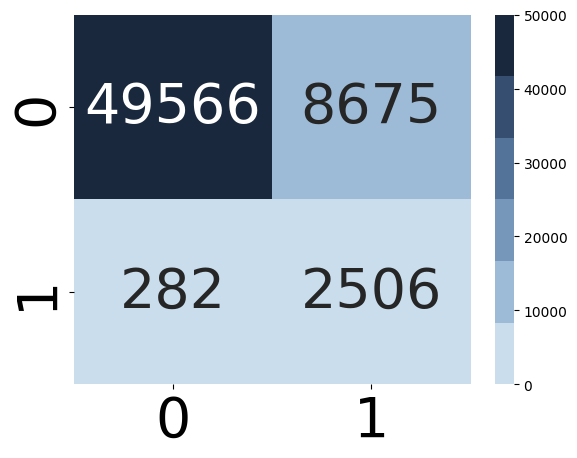

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[49566 , 8675],
 [  282 , 2506]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=50000)# font size
plt.savefig('ABS_SVC_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("ABS_SVC_UB_testMat.png")

In [ ]:
print(f"Test Set: {len(Xt_test)}")
print(Yt_test.value_counts())
print(matrix)

Test Set: 61029
0    58241
1     2788
Name: Target, dtype: int64
[[49566  8675]
 [  282  2506]]


# Dual active models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.2 MB/s eta 0:00:00

real	0m14.603s
user	0m8.286s
sys	0m0.924s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [ ]:
############################################Sexual data
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

# Molecular Morgan Fingerprint (MFP)

,Smiles,S_Hit,Target,ROMol,Input
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes,1,,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No,0,,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No,0,,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."

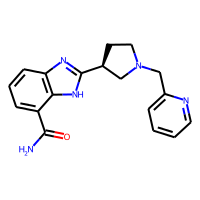
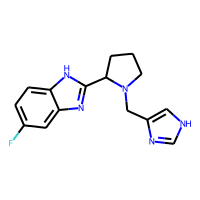
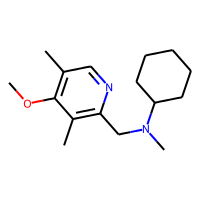
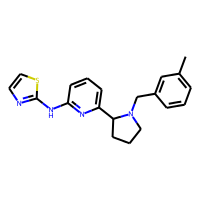
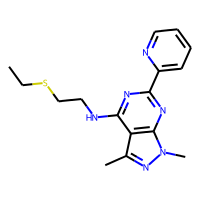
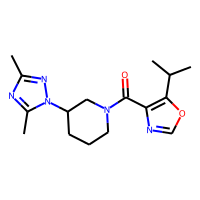
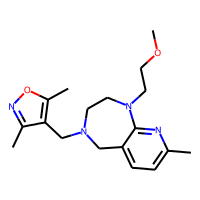
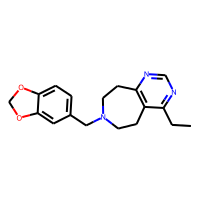
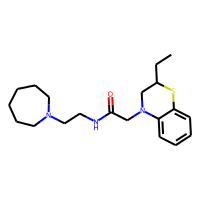
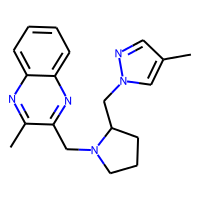

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

## Hyperparameter tuning


---



---



In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto",class_weight='balanced', probability=True)
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto", class_weight='balanced', probability=True)

In [ ]:
## https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)# Train a SVC model using different kernal
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1788
           1       0.10      1.00      0.18       191

    accuracy                           0.10      1979
   macro avg       0.05      0.50      0.09      1979
weighted avg       0.01      0.10      0.02      1979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.99      0.95      0.96      1788
           1       0.63      0.87      0.73       191

    accuracy                           0.94      1979
   macro avg       0.81      0.91      0.85      1979
weighted avg       0.95      0.94      0.94      1979

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1788
           1       0.61      0.87      0.72       191

    accuracy                           0.93      1979
   macro avg       0.80      0.91      0.84      1979
weighted avg       0.95      0.93      0.94      1979

Evaluation: Linear kernel
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1788
           1       0.61      0.82      0.70       191

    accuracy                           0.93      1979
   macro avg       0.79      0.88      0.83      197

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid,cv=KFold(n_splits=10), refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(Xt_train, Yt_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.889 total time= 2.2min
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.909 total time= 2.5min
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.891 total time= 2.4min
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.909 total time= 2.4min
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.906 total time= 2.3min
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.929 total time= 2.3min
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.925 total time= 2.3min
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.912 total time= 2.3min
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.904 total time= 2.4min
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.915 total time= 2.4min
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.890 total time= 2.4min
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)


*   [CV 10/10] END .C=1000, gamma=0.001, kernel=rbf;, score=0.961 total time=  20.2s
*  [CV 10/10] END ..C=1000, gamma=0.01, kernel=rbf;, score=0.976 total time=  31.9s
*  [CV 10/10] END ...C=100, gamma=0.01, kernel=rbf;, score=0.976 total time=  30.7s
*  [CV 10/10] END ....C=10, gamma=0.01, kernel=rbf;, score=0.976 total time=  27.7s
*  [CV 10/10] END .....C=1, gamma=0.01, kernel=rbf;, score=0.977 total time=  37.5s

## Training

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', C=10, kernel= "rbf", gamma =0.01, probability=True)

svc_model.fit(Xt_train, Yt_train)


In [ ]:
svc_model

SVC(C=10, class_weight='balanced', gamma=0.01, probability=True)

In [ ]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(svc_model, 'sexualsSVCFinalHPT_UMFP_model5005.pkl')

#Load sexual screening test set

In [ ]:
import pandas as pd
df1= pd.read_csv("sexualsUntrainedTest.csv")
df1

,Unnamed: 0,mol,S_Hit,Smiles
0,25658,<rdkit.Chem.rdchem.Mol object at 0x7fc9363b4c10>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,39559,<rdkit.Chem.rdchem.Mol object at 0x7fc9362189e0>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,36544,<rdkit.Chem.rdchem.Mol object at 0x7fc936195770>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,58789,<rdkit.Chem.rdchem.Mol object at 0x7fc935d5bd80>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,15213,<rdkit.Chem.rdchem.Mol object at 0x7fc9365e8190>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...,...
62370,50615,<rdkit.Chem.rdchem.Mol object at 0x7fc935ffa1f0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,57063,<rdkit.Chem.rdchem.Mol object at 0x7fc935f145f0>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,19513,<rdkit.Chem.rdchem.Mol object at 0x7fc9364a6ff0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,41985,<rdkit.Chem.rdchem.Mol object at 0x7fc93607fa00>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
compounds = []


for _, compound_key, smiles in df1[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
dff= pd.DataFrame (compounds, columns = ['mol', 'S_Hit', "Smiles"])
sxl=dff
sxl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c9e0>,No,Cn1cc(CN2CC[C@@H]3[C@@H](CCC(=O)N3CCc3c[nH]cn3...
1,<rdkit.Chem.rdchem.Mol object at 0x7f71c322d000>,No,CC1(C)CN=C(N2CCN(CC3CCOC3)CC2)S1
2,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c580>,No,COCCC(=O)N1CCN(CC2CC2)c2ccccc21
3,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c740>,No,CC(CC(=O)O)CC(=O)Nc1sc2c(c1C(N)=O)CCc1ccccc1-2
4,<rdkit.Chem.rdchem.Mol object at 0x7f71c322c7b0>,No,Clc1ccccc1CN1CCc2nc(C3CCCCN3)ncc2C1
...,...,...,...
62370,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d49e0>,No,CC[C@@H](c1ccccc1)n1c(C2CC2)n[nH]c1=O
62371,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4a50>,No,CCn1ncc(S(=O)(=O)N[C@@H]2CC[C@@H](n3ccnc3C)[C@...
62372,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4ac0>,No,O=C(Nc1ccc(F)cc1)C1CNCCN1C(=O)CC1CCCCC1
62373,<rdkit.Chem.rdchem.Mol object at 0x7f71c43d4b30>,No,CNC(=O)CN1CCC(NC(=O)CC(C)CCc2ccccc2)CC1


In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
#PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
#sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["mol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

,mol,S_Hit,Smiles,Input,Target
33991,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3dc21f0>,No,CC(C)Oc1cccc2c1c(NC(=O)CN(C)C)nn2CC(F)(F)F,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0
68769,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34a7140>,Yes,CCc1c(-c2ccccc2)nc2c(c(C)c(C)n2CCN(C)C)c1N,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
29581,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3efc6d0>,No,Cc1cc(CN(CCCO)c2ccccc2)on1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
13351,<rdkit.Chem.rdchem.Mol object at 0x7fc3b422bed0>,No,CCCc1noc(-c2cn(CC(=O)N(CC)CC)nn2)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
15429,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4089460>,No,O=C(c1ccccn1)N1CCN(c2cnnc(N3CCCC3)c2)CC1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...
64363,<rdkit.Chem.rdchem.Mol object at 0x7fc3b35e57e0>,No,N#Cc1ccc(C(=O)N(Cc2ccncc2)C2CC2)cc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
41138,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3ae3ae0>,No,CC1(C(N)=O)CN(CC2CCOCC2)CCO1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
62527,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3596ab0>,No,N#Cc1ccc(NCCNc2ccc(C(F)(F)F)cn2)nc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
58523,<rdkit.Chem.rdchem.Mol object at 0x7fc3b36e00b0>,No,Cc1noc(CN(C)C(=O)CCn2cnc3ccccc32)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

In [ ]:
mfp= []
mfp = sxl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
Xt_test = df
Yt_test= sxl["Target"]

#SVC

In [ ]:
import pandas
from sklearn import model_selection
import joblib

# load the model from disk
svc_model = joblib.load('sexualsSVCFinalHPT_UMFP_model5005.pkl')
#result = loaded_model.score(Xt_test, Yt_test)
#print(result)


In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

svc_predict = svc_model.predict(Xt_test)# check performance


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,svc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,svc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,svc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,svc_predict)
print('F1 score: %f' % f1)
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, svc_predict))
print('Accuracy score:',accuracy_score(Yt_test, svc_predict))
print('F1 score:',f1_score(Yt_test, svc_predict))
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, svc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, svc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, svc_predict)
print(matrix)
cm= confusion_matrix(Yt_test,svc_predict)
cm

Accuracy: 0.993058
Recall 0.658120
precision 0.163830
F1 score: 0.262351
ROCAUC score: 0.8259036081725535
Accuracy score: 0.993058116232465
F1 score: 0.262350936967632
Cohens kappa: 0.260129
ROC AUC: 0.825904
[[61865   393]
 [   40    77]]


array([[61865,   393],
       [   40,    77]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

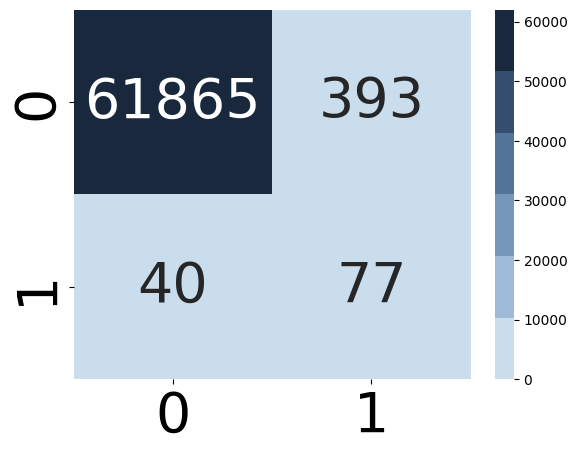

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[61865 ,  393],
 [   40 ,   77]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=62000)# font size
plt.savefig('Dual_SVC_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("Dual_SVC_UB_testMat.png")

In [ ]:
print(f"Test Set: {len(Xt_test)}")
print(Yt_test.value_counts())
print(matrix)

Test Set: 62375
0    62258
1      117
Name: Target, dtype: int64
[[61865   393]
 [   40    77]]
